## Adapted from original EEGNet implementation (EEGModels.py)

In [ ]:
"""
 ARL_EEGModels - A collection of Convolutional Neural Network models for EEG
 Signal Processing and Classification, using Keras and Tensorflow

 Requirements:
    (1) tensorflow == 2.X (as of this writing, 2.0 - 2.3 have been verified
        as working)

 To run the EEG/MEG ERP classification sample script, you will also need

    (4) mne >= 0.17.1
    (5) PyRiemann >= 0.2.5
    (6) scikit-learn >= 0.20.1
    (7) matplotlib >= 2.2.3

 To use:

    (1) Place this file in the PYTHONPATH variable in your IDE (i.e.: Spyder)
    (2) Import the model as

        from EEGModels import EEGNet

        model = EEGNet(nb_classes = ..., Chans = ..., Samples = ...)

    (3) Then compile and fit the model

        model.compile(loss = ..., optimizer = ..., metrics = ...)
        fitted    = model.fit(...)
        predicted = model.predict(...)

 Portions of this project are works of the United States Government and are not
 subject to domestic copyright protection under 17 USC Sec. 105.  Those
 portions are released world-wide under the terms of the Creative Commons Zero
 1.0 (CC0) license.

 Other portions of this project are subject to domestic copyright protection
 under 17 USC Sec. 105.  Those portions are licensed under the Apache 2.0
 license.  The complete text of the license governing this material is in
 the file labeled LICENSE.TXT that is a part of this project's official
 distribution.
"""

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


def EEGNet(nb_classes, Chans = 64, Samples = 128,
             dropoutRate = 0.5, kernLength = 64, F1 = 8,
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:

        1. Depthwise Convolutions to learn spatial filters within a
        temporal convolution. The use of the depth_multiplier option maps
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn
        spatial filters within each filter in a filter-bank. This also limits
        the number of free parameters to fit when compared to a fully-connected
        convolution.

        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions.


    While the original paper used Dropout, we found that SpatialDropout2D
    sometimes produced slightly better results for classification of ERP
    signals. However, SpatialDropout2D significantly reduced performance
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.

    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the
    kernel lengths for double the sampling rate, etc). Note that we haven't
    tested the model performance with this rule so this may not work well.

    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D.

    Inputs:

      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D.
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import Packages

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Brainhack')


from EEGModels import EEGNet       # import EEGNET model from EEGModels.py

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

## Load Preprocessed Data and Labels

In [ ]:
import numpy as np

# import X and Y data
X_epochs = np.load("/content/drive/MyDrive/Brainhack/Copy of X_epochs_data.npy")         # shape: n_epochs=4308, n_channels=19, n_times=1025
X_features = np.load("/content/drive/MyDrive/Brainhack/Copy of X_features.npy")          # shape: n_epochs=4308, n_bandpower_features=95
y_labels = np.load("/content/drive/MyDrive/Brainhack/Copy of y_epoch_labels.npy")        # shape: n_epochs=4308,

print(X_epochs.shape)
print(X_features.shape)
print(y_labels.shape)

(4308, 19, 1025)
(4308, 95)
(4308,)


In [ ]:
X = X_epochs.reshape(X_epochs.shape[0], X_epochs.shape[1], X_epochs.shape[2], 1)

y = to_categorical(y_labels)

In [ ]:
def EEGNet(nb_classes, Chans = 64, Samples = 128,
             dropoutRate = 0.5, kernLength = 64, F1 = 8,
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.4,     # train size:validation size = 60:40
    shuffle=True,
    stratify=y_labels,
    random_state=123
)

print("Train size:", len(X_train))    # Train size: 2584
print("Validation size:", len(X_val))    # Validation size: 1724

Train size: 2584
Validation size: 1724


In [ ]:
model = EEGNet(nb_classes=2, Chans=X.shape[1], Samples=X.shape[2],
               dropoutRate=0.25, kernLength=64, F1=8, D=4, F2=32,
               norm_rate=0.25, dropoutType='Dropout')

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_val, y_val))


Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.4778 - loss: 0.6932 - val_accuracy: 0.5070 - val_loss: 0.6931
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5631 - loss: 0.6900 - val_accuracy: 0.5070 - val_loss: 0.6931
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6419 - loss: 0.6458 - val_accuracy: 0.5070 - val_loss: 0.7852
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8069 - loss: 0.4590 - val_accuracy: 0.5070 - val_loss: 1.0339
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8520 - loss: 0.3768 - val_accuracy: 0.5081 - val_loss: 1.3776
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8685 - loss: 0.3470 - val_accuracy: 0.4930 - val_loss: 0.7627
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8661 - loss: 0.3376 - val_accuracy: 0.4930 - val_loss: 2.9237
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8760 - loss: 0.3277 - val_accuracy: 0

## Hyperparameter Tuning

### Using Keras-Tuner

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.0 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

def build_model(hp):
    from EEGModels import EEGNet  # make sure EEGModels.py in currect directory
    model = EEGNet(
        nb_classes=2,
        Chans=X.shape[1],
        Samples=X.shape[2],
        dropoutRate=hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1),
        kernLength=hp.Choice('kernLength', [32, 64, 128]),
        F1=hp.Choice('F1', [2, 4, 6]),
        D=hp.Choice('D', [3, 4, 5]),
        F2=hp.Choice('F2', [16, 32, 64]),
        norm_rate=0.3,
        dropoutType='Dropout'
    )

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [0.001, 0.0005, 0.0001])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='eegnet_tuning',
    project_name='mdd_detection'
)

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=10,
                           restore_best_weights=True)

tuner.search(X_train, y_train,
             epochs=20,
             validation_data=(X_val, y_val),
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])


Trial 5 Complete [00h 00m 30s]
val_accuracy: 0.5214617252349854

Best val_accuracy So Far: 0.7482598423957825
Total elapsed time: 00h 02m 53s


### Using For-Loops Manually

In [ ]:
best_acc = 0
best_params = {}

for F1 in [8, 16]:
    for D in [2, 4]:

          model = EEGNet(nb_classes=2,
                          Chans=X.shape[1],
                          Samples=X.shape[2],
                          F1=F1, D=D, F2=F1*D,
                          dropoutRate=0.25,
                          dropoutType='Dropout')

          model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(learning_rate=0.001),
                        metrics=['accuracy'])

          history = model.fit(X_train, y_train,
                              batch_size=32,
                              epochs=30,
                              verbose=0,
                              validation_data=(X_val, y_val))

          val_acc = history.history['val_accuracy'][-1]
          print(f"F1={F1}, D={D}, val_acc={val_acc:.4f}")

          if val_acc > best_acc:
              best_acc = val_acc
              best_params = {'F1': F1, 'D': D}

print("Best Params:", best_params)
print("Best Val Acc:", best_acc)


F1=8, D=2, val_acc=0.4930
F1=8, D=4, val_acc=0.4942
F1=16, D=2, val_acc=0.4942
F1=16, D=4, val_acc=0.8219
Best Params: {'F1': 16, 'D': 4}
Best Val Acc: 0.8219257593154907


## Validation Performance

Test loss: 0.38601458072662354
Test accuracy: 0.8219257593154907
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


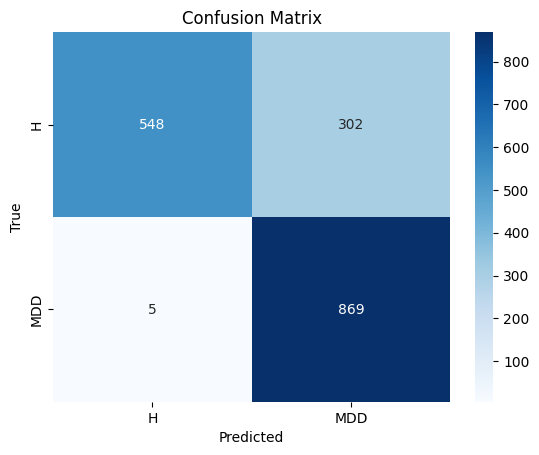

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

# Confusion Matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['H', 'MDD'],
            yticklabels=['H', 'MDD'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


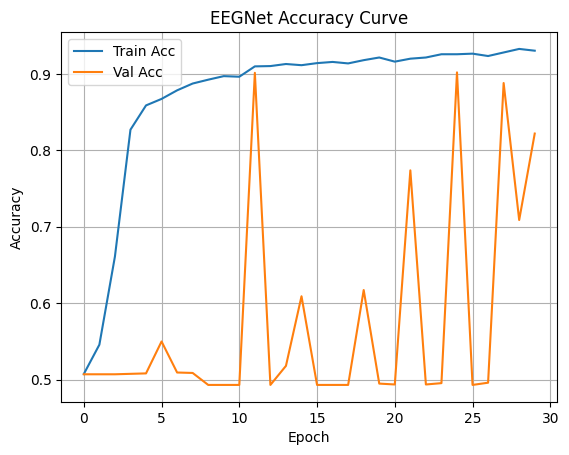

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('EEGNet Accuracy Curve')
plt.grid()
plt.show()
